## QCNNs for Classifying Quantum Phases of Matter 

#### Introduction: 
In this notebook we walk through the QCNN model and the logic used to generate our final results. This code is then streamlined (removing excess print statments and saving figures of interest) and condensed into the python file qcnn_classify_phases.py which was then run using cloud computing resources to accelerate the learning process. 

This notebook serves as a useful tool for anyone looking to play around with the model and generate some plots quickly. 

#### Background: 

In this project we are attempting to reproduce the results of this paper: https://arxiv.org/pdf/1810.03787.pdf 
The authors begin by considering the ground state wavefunctions of a family of hamiltonians parameterized by $h_{1}, h_{2}$: 

$$\hat{H} = -J \sum_{i=1}^{N-2}(\hat{Z}_{i}\hat{X}_{i+1}\hat{Z}_{i+2}) -h_{1}\sum_{i=1}^{N}(\hat{X}_{i}) -h_{2}\sum_{i=1}^{N-1}(\hat{X}_{i}\hat{X}_{i+1}) $$

The ground states of this system exist in certain  phases of matter (paramagnetic, antiferromagnetic, SPT) depnding on the values of $h_{1}, h_{2}$.
The authors then ask the question, is it possible for a quantum machine learning model to determine which state a of matter a particular wave function is from? The model used is the QCNN model they present in the paper.  

#### This Project: 
We have created a custom module 'qml' which allows users to implment their own QCNN models! We have replicated all of the layers that were presented in the original paper (called legacy layers). Beyond that we have implmented our own version of the convolutional layer which uses fewer parameters but achieves the same level of expressibility thus reducing training time significantly ! 


In [4]:
import copy
import sys 
import numpy as np
import matplotlib.pyplot as plt 

sys.path.insert(0, "../qml_src/")

from qml import qcnn as q
from qml import layers as cl # custom layers 


In [5]:
## read / import data 
num_qubits = 9
training_fname = "./data_fldr/dataset_n={}_train.txt".format(num_qubits)
test_fname = "./data_fldr/dataset_n={}_test.txt".format(num_qubits)

def read_eigenvectors(file):
    with open(file, 'r+') as f:
        textData = f.readlines()

        h_vals = []
        for i in range(len(textData)):
            h1h2, eigenvector = textData[i].split("_")

            h_vals.append(tuple(map(float, h1h2[1: -1].split(', '))))
            textData[i] = eigenvector

        return h_vals, np.loadtxt(textData, dtype=complex)

h1h2_train, train_data = read_eigenvectors(training_fname)
h1h2_test, test_data = read_eigenvectors(test_fname)

# To get the correct labels of the training set we use the fact that data points with
# h1 <= 1 are in the SPT phase and thus assigned the label 1 while h1 > 1 are in the paramagnetic phase 
# This is only true for the training set which has h2 = 0 for all samples, 

labels = np.zeros(40)

for index, h1h2 in enumerate(h1h2_train):
    h1, h2 = h1h2
    if h1 <= 1: 
        labels[index] = 1.0


#### Model:
Below we initialize our model then specifiy the structure of the model by adding layers sequentially. The particular model used in the paper had 3 sets of convolutional layers (one 4-qubit convolution layer and three 3-qubit convolution layers) followed by a single pooling layer (pooling groups of 3 qubits down to 1 qubit) and finally a fully connected layer. 

Once we have defined the structure of the model, we use a built-in function to initialize all of the parameters of the model. We have the capability to initialize the parameters to 0s, 1s, random floats or to load a pre determined set of parameters provided they have the same shape (i.e they were exported from a model with the same structure). 

Finally, we can perform a visual check by using the class method Qcnn.generate_circ(parameters) to get a quantumcircuit object and then visualize it using qiskits circ.draw functionality! 

In [6]:
## Model 
my_qcnn = q.Qcnn(num_qubits)

## Add Custom layer: 
legacy_fully_connected_layer = cl.get_legacy_fc_layer(num_qubits // 3)  # because we will be pooling out 2/3 of the qubits 
my_qcnn.Layers[legacy_fully_connected_layer.name] = legacy_fully_connected_layer # we have to add it to our model class variable


## def structure: 
my_qcnn.add_layer(my_qcnn.Layers["legacy_conv4_layer"], kwargs={"label":"C4_1"} )
my_qcnn.add_layer(my_qcnn.Layers["legacy_conv_layer"], kwargs={"label": "C2"})
my_qcnn.add_layer(my_qcnn.Layers["legacy_conv_layer"], kwargs={"label": "C3", "start_index": 1})
my_qcnn.add_layer(my_qcnn.Layers["legacy_conv_layer"], kwargs={"label": "C4", "start_index": 2})
my_qcnn.add_layer(my_qcnn.Layers["legacy_pool_layer"], kwargs={"label": "P1", 
                                                               "update_active_qubits": {"group_len": 3, "target": 1}})
                                                              # after this we have pooled out 2 out of every 3 qubits 

my_qcnn.add_layer(my_qcnn.Layers[legacy_fully_connected_layer.name], kwargs={})  # this is the custom layer we added earlier ! 

## Initialize parameters: 
my_qcnn.initialize_params(random=True)
initial_params = copy.deepcopy(my_qcnn.params)

## visual check : 
# circ = my_qcnn.generate_circ(my_qcnn.params)
# circ.draw(reverse_bits=True)

#### Learning:
In this section we train the parameters of the model. We use a two metrics to terminate training. The first is if the relative loss between iterations is $ < 10^{-5}$. The second is a hard cap on the total number of iterations. 

For users who just want to run the code quickly and plot some results we would recommend you drop the number of iterations to 20 (approx 5 - 7 min training time). Beyond that, we have set the total iterations to 50 (approx 20 - 30 min training time) to allow for the model to make more progress in training the parameters. When this code is run in a script, we can make use of multi-processing, allowing us to reduce our training time by a factor of 2 - 4. Even still, training for 1000 iterations takes a significant amount! 

In [7]:
## Learning as described in paper: 

total_iterations = 50      # few iterations for quicker training and plotting 
# total_iterations = 1000  # our results showed that the model converges in ~ 500 iterations so setting upper limit to 1000
                           # should be fine 
    
learning_rate = 100000  # intial value was 10 but this quantity doesn't learn fast enough ! 
successive_loss = 1.0 # initialize to arbitrary value > 10^-5
loss_lst = []  # initialize 
iteration_num = 1 

while (abs(successive_loss) > 1e-5) and (iteration_num <= total_iterations):
    pred = my_qcnn.forward(train_data, my_qcnn.params.copy())  # we use a copy of the params to avoid potential aliasing 
    loss = my_qcnn.mse_loss(pred, labels)
    
    print("---- Iteration : {}, Loss {} ----------------------".format(iteration_num, loss))
    
    if iteration_num == 1:
        pass 
    
    else: 
        successive_loss = loss - loss_lst[-1]       
        if successive_loss < 0: 
            learning_rate *= 1.05  # if loss decreases, increase learning rate by 5%
        else:
            learning_rate /= 2  # if it gets bigger, decrease learning rate by 50% 
            
    grad_mat = my_qcnn.compute_grad(train_data, labels)
#     grad_mat = my_qcnn.compute_grad_w_mp(train_data, labels)  # with multi processing, causes errors when used in a notebook
    my_qcnn.update_params(grad_mat, learning_rate)  # this layer will change the parameters (my_qcnn.params) internally
    
    loss_lst.append(loss)
    iteration_num += 1 
    
# params = copy.deepcopy(my_qcnn.params)

---- Iteration : 1, Loss 0.5779687717059793 ----------------------
---- Iteration : 2, Loss 0.5775901951020419 ----------------------
---- Iteration : 3, Loss 0.5771957742348002 ----------------------
---- Iteration : 4, Loss 0.5767848324470479 ----------------------
---- Iteration : 5, Loss 0.5763568715971005 ----------------------
---- Iteration : 6, Loss 0.5759116847267709 ----------------------
---- Iteration : 7, Loss 0.5754486440774624 ----------------------
---- Iteration : 8, Loss 0.5749671308506311 ----------------------
---- Iteration : 9, Loss 0.5744665739980416 ----------------------
---- Iteration : 10, Loss 0.5739468968014353 ----------------------
---- Iteration : 11, Loss 0.5734073389924231 ----------------------
---- Iteration : 12, Loss 0.5728479010855712 ----------------------
---- Iteration : 13, Loss 0.572267574582854 ----------------------
---- Iteration : 14, Loss 0.5716669659664118 ----------------------
---- Iteration : 15, Loss 0.5710452333300594 -------------

#### Results: 


In [8]:
## heat_map for initial params (graph visualization) :
initial_predictions = my_qcnn.forward(test_data, initial_params)
print('got predictions!')

got predictions!


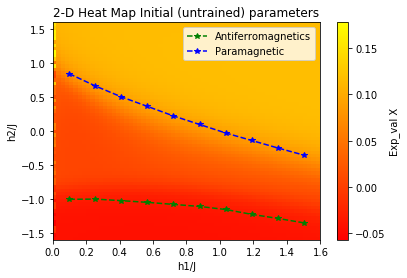

In [10]:
pred_mat = initial_predictions.reshape((64, 64), order='F')
h1_vals = np.linspace(0, 1.6, 64)
h2_vals = np.linspace(-1.6, 1.6, 64)

# plot heat map 
heat_map = plt.pcolormesh(h1_vals, h2_vals, pred_mat, cmap = 'autumn')
plt.colorbar(heat_map, label="Exp_val X")
plt.title( "2-D Heat Map Initial (untrained) parameters" )
plt.xlabel('h1/J')
plt.ylabel('h2/J')

# plot phase boundaries
h1_vals = [0.1000, 0.2556, 0.4111, 0.5667, 0.7222, 0.8778, 1.0333, 1.1889, 1.3444, 1.5000]
anti_ferro_mag_boundary = [-1.004, -1.0009, -1.024, -1.049, -1.079, -1.109, -1.154,  -1.225, -1.285, -1.35]
para_mag_boundary = [0.8439, 0.6636, 0.5033, 0.3631, 0.2229, 0.09766, -0.02755, -0.1377, -0.2479, -0.3531]

plt.plot(h1_vals, anti_ferro_mag_boundary,"g--*", label="Antiferromagnetics")
plt.plot(h1_vals, para_mag_boundary, "b--*", label="Paramagnetic")

plt.legend()
plt.show()

In [11]:
## Using model on test data (graph visualization) :
predictions = my_qcnn.forward(test_data, my_qcnn.params.copy())
print('got predictions!')

got predictions!


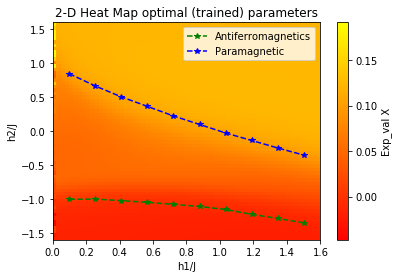

In [12]:
pred_mat = predictions.reshape((64, 64), order='F')
h1_vals = np.linspace(0, 1.6, 64)
h2_vals = np.linspace(-1.6, 1.6, 64)

# plot heat map 
heat_map = plt.pcolormesh(h1_vals, h2_vals, pred_mat, cmap = 'autumn')
plt.colorbar(heat_map, label="Exp_val X")
plt.title( "2-D Heat Map optimal (trained) parameters" )
plt.xlabel('h1/J')
plt.ylabel('h2/J')

# plot phase boundaries
h1_vals = [0.1000, 0.2556, 0.4111, 0.5667, 0.7222, 0.8778, 1.0333, 1.1889, 1.3444, 1.5000]
anti_ferro_mag_boundary = [-1.004, -1.0009, -1.024, -1.049, -1.079, -1.109, -1.154,  -1.225, -1.285, -1.35]
para_mag_boundary = [0.8439, 0.6636, 0.5033, 0.3631, 0.2229, 0.09766, -0.02755, -0.1377, -0.2479, -0.3531]

plt.plot(h1_vals, anti_ferro_mag_boundary, "g--*", label="Antiferromagnetics")
plt.plot(h1_vals, para_mag_boundary, "b--*", label="Paramagnetic")
plt.legend()

plt.show()

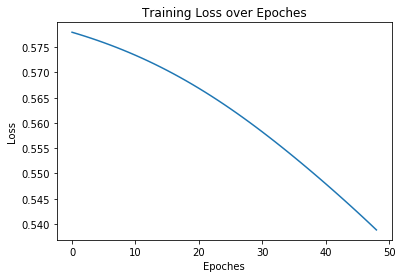

In [13]:
## Loss plot: 
x_axis = range(len(loss_lst))

plt.plot(x_axis, loss_lst)
plt.title('Training Loss over Epoches')
plt.xlabel('Epoches')
plt.ylabel("Loss")
plt.show()